# Bitcoin as a Portfolio Diversifier: An In-Depth Analysis

This analysis explores Bitcoin's potential role as a portfolio diversifier by examining:
- Volatility characteristics across different time horizons
- Downside risk through maximum drawdown analysis
- Portfolio performance metrics with varying Bitcoin allocations
- Risk-adjusted returns using Sharpe and Sortino ratios
- Upside/downside capture relative to equities
- Expected shortfall (conditional value at risk)

We compare three portfolio strategies:
1. **Baseline**: 80% S&P 500 / 20% Bonds
2. **5% Bitcoin**: 75% S&P 500 / 20% Bonds / 5% Bitcoin
3. **10% Bitcoin**: 70% S&P 500 / 20% Bonds / 10% Bitcoin

All portfolios are rebalanced annually to maintain target allocations.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for professional charts
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Data Loading and Preparation

We begin by loading historical price data for Bitcoin, S&P 500, bonds (AGG), and the VIX volatility index.

In [2]:
# Load data files
btc_df = pd.read_csv('../dat/dec2025/btc.csv', parse_dates=['date'], index_col='date')
spx_df = pd.read_csv('../dat/dec2025/spx.csv', parse_dates=['date'], index_col='date')
agg_df = pd.read_csv('../dat/dec2025/agg.csv', parse_dates=['date'], index_col='date')
vix_df = pd.read_csv('../dat/dec2025/vix.csv', parse_dates=['date'], index_col='date')

# Combine into single dataframe
prices = pd.DataFrame({
    'BTC': btc_df['close'],
    'SPX': spx_df['close'],
    'AGG': agg_df['close'],
    'VIX': vix_df['close']
})

# Forward fill any missing values
prices = prices.ffill()

# Display summary
print(f"Data Range: {prices.index[0].strftime('%Y-%m-%d')} to {prices.index[-1].strftime('%Y-%m-%d')}")
print(f"Total Trading Days: {len(prices)}")
print(f"\nFirst few rows:")
prices.head()

Data Range: 2015-01-01 to 2025-12-23
Total Trading Days: 4010

First few rows:


,BTC,SPX,AGG,VIX
date,,,,
2015-01-01,314.96,NaN,NaN,NaN
2015-01-02,315.81,2058.20,86.67,17.79
2015-01-03,278.22,2058.20,86.67,17.79
2015-01-04,264.19,2058.20,86.67,17.79
2015-01-05,274.84,2020.58,86.86,19.92


In [3]:
# Calculate daily returns
returns = prices.pct_change().dropna()

# Display summary statistics
print("Daily Return Statistics (%)\n" + "="*50)
summary = returns.describe() * 100
summary

Daily Return Statistics (%)


,BTC,SPX,AGG,VIX
count,400800.0000,400800.0000,400800.0000,400800.0000
mean,0.2056,0.0346,0.0039,0.2263
std,3.5923,0.9372,0.2755,7.1732
min,-38.8124,-11.9841,-4.0037,-35.7539
25%,-1.2497,-0.1448,-0.0703,-2.4938
50%,0.1301,0.0000,0.0000,0.0000
75%,1.6666,0.2996,0.0936,1.4368
max,27.2020,9.5150,2.3715,117.4825


## 2. Volatility Analysis

Volatility is a key measure of risk. We compare Bitcoin's volatility to the S&P 500 across multiple time horizons:
- **Full Period**: Overall volatility across the entire dataset
- **30-Day Rolling**: Short-term volatility patterns
- **60-Day Rolling**: Medium-term volatility trends
- **180-Day Rolling**: Longer-term volatility behavior

Volatility is annualized assuming 252 trading days per year.

In [4]:
# Calculate annualized volatility (full period)
annual_vol = returns[['BTC', 'SPX', 'AGG']].std() * np.sqrt(252) * 100

print("Annualized Volatility (%)\n" + "="*50)
for asset in annual_vol.index:
    print(f"{asset:10s}: {annual_vol[asset]:6.2f}%")

# Calculate rolling volatilities
windows = [30, 60, 180]
rolling_vols = {}

for window in windows:
    rolling_vols[window] = returns[['BTC', 'SPX']].rolling(window=window).std() * np.sqrt(252) * 100

print(f"\nCalculated rolling volatilities for {windows} day windows")

Annualized Volatility (%)
BTC       :  57.03%
SPX       :  14.88%
AGG       :   4.37%

Calculated rolling volatilities for [30, 60, 180] day windows


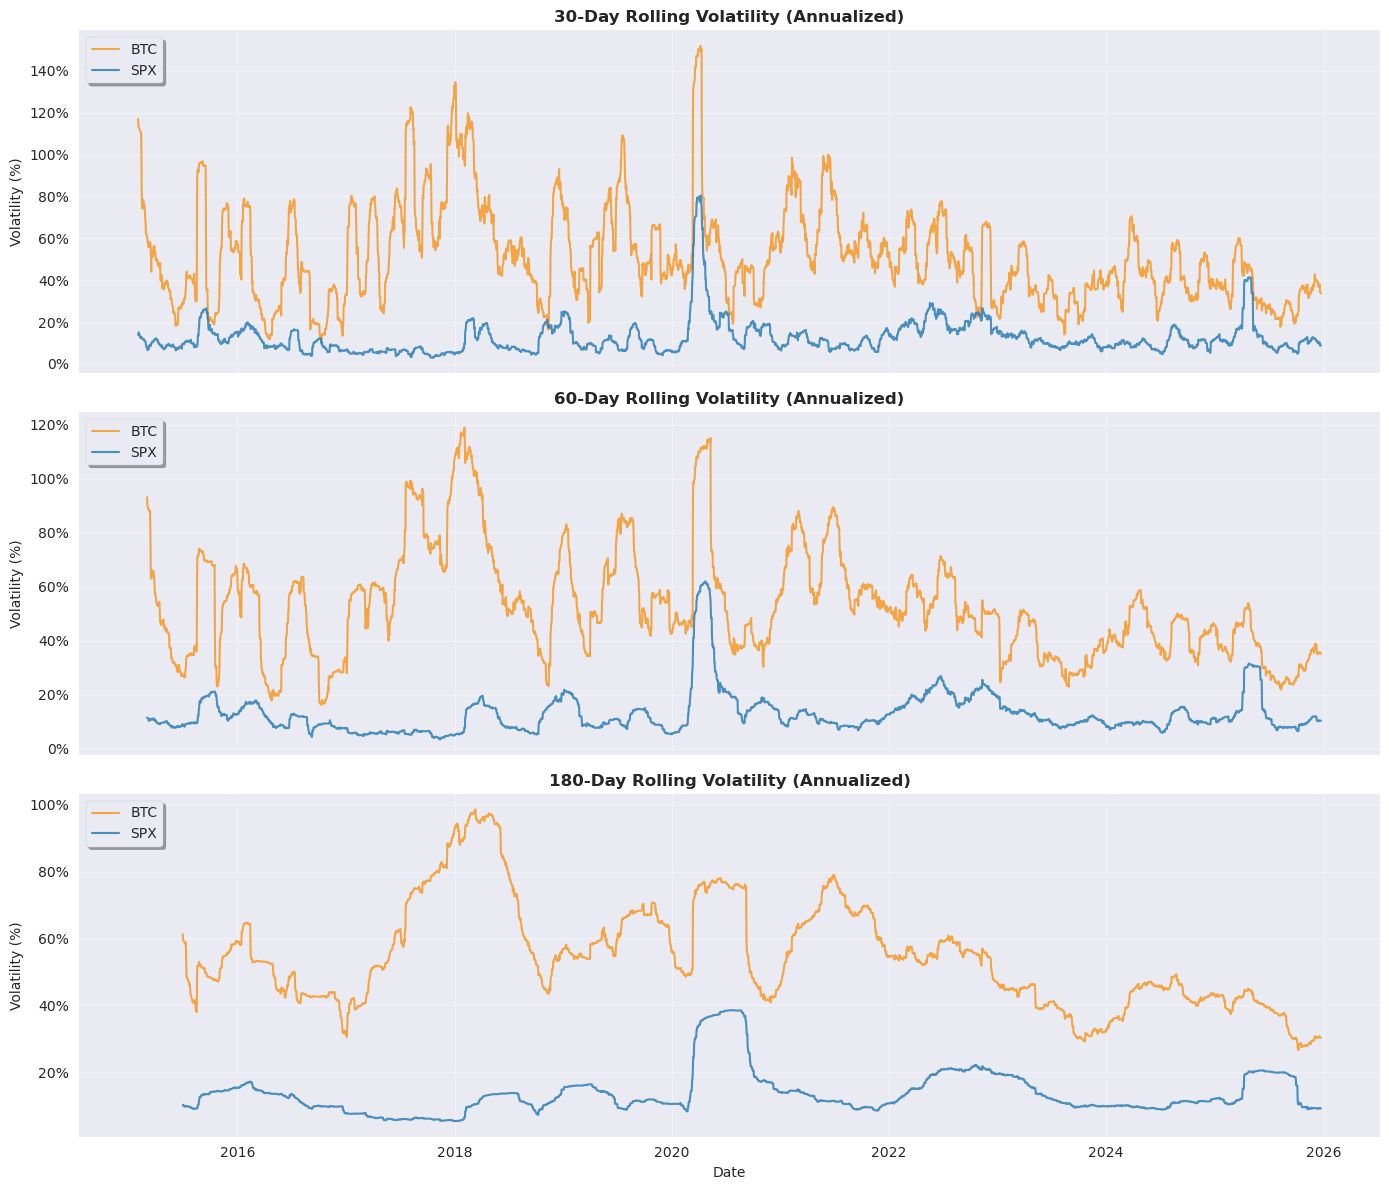


Key Insights:
- Bitcoin exhibits significantly higher volatility than S&P 500 across all timeframes
- Volatility varies considerably over time for both assets
- Longer rolling windows (180-day) smooth out short-term volatility spikes


In [6]:
# Visualization: Rolling Volatility Comparison
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
colors = {'BTC': '#f7931a', 'SPX': '#1f77b4'}

for idx, window in enumerate(windows):
    ax = axes[idx]
    
    for asset in ['BTC', 'SPX']:
        ax.plot(rolling_vols[window].index, rolling_vols[window][asset] / 100, 
                label=asset, color=colors[asset], linewidth=1.5, alpha=0.8)
    
    ax.set_title(f'{window}-Day Rolling Volatility (Annualized)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Volatility (%)', fontsize=10)
    ax.legend(loc='upper left', frameon=True, shadow=True)
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

axes[2].set_xlabel('Date', fontsize=10)
plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("- Bitcoin exhibits significantly higher volatility than S&P 500 across all timeframes")
print("- Volatility varies considerably over time for both assets")
print("- Longer rolling windows (180-day) smooth out short-term volatility spikes")

## 3. Maximum Drawdown Analysis

Maximum drawdown measures the largest peak-to-trough decline, representing the worst possible loss an investor could have experienced. This metric is crucial for understanding downside risk and psychological tolerance for losses.

**Interpretation**: A lower (more negative) drawdown indicates greater downside risk. We examine both the magnitude and duration of drawdowns.

In [7]:
def calculate_drawdown(prices_series):
    """Calculate drawdown series from price series"""
    cumulative = (1 + prices_series.pct_change()).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    return drawdown

def max_drawdown_stats(prices_series):
    """Calculate maximum drawdown and related statistics"""
    dd = calculate_drawdown(prices_series)
    max_dd = dd.min()
    max_dd_date = dd.idxmin()
    
    # Find peak before max drawdown
    cumulative = (1 + prices_series.pct_change()).cumprod()
    peak_date = cumulative.loc[:max_dd_date].idxmax()
    duration_days = (max_dd_date - peak_date).days
    
    return {
        'Max Drawdown': max_dd,
        'Peak Date': peak_date,
        'Trough Date': max_dd_date,
        'Duration (days)': duration_days
    }

# Calculate drawdowns
dd_btc = calculate_drawdown(prices['BTC'])
dd_spx = calculate_drawdown(prices['SPX'])

# Get statistics
btc_stats = max_drawdown_stats(prices['BTC'])
spx_stats = max_drawdown_stats(prices['SPX'])

print("Maximum Drawdown Analysis\n" + "="*70)
print("\nBitcoin:")
for key, value in btc_stats.items():
    if 'Drawdown' in key:
        print(f"  {key:20s}: {value:.2%}")
    elif 'Date' in key:
        print(f"  {key:20s}: {value.strftime('%Y-%m-%d')}")
    else:
        print(f"  {key:20s}: {value}")

print("\nS&P 500:")
for key, value in spx_stats.items():
    if 'Drawdown' in key:
        print(f"  {key:20s}: {value:.2%}")
    elif 'Date' in key:
        print(f"  {key:20s}: {value.strftime('%Y-%m-%d')}")
    else:
        print(f"  {key:20s}: {value}")

Maximum Drawdown Analysis

Bitcoin:
  Max Drawdown        : -83.80%
  Peak Date           : 2017-12-16
  Trough Date         : 2018-12-15
  Duration (days)     : 364

S&P 500:
  Max Drawdown        : -33.92%
  Peak Date           : 2020-02-19
  Trough Date         : 2020-03-23
  Duration (days)     : 33


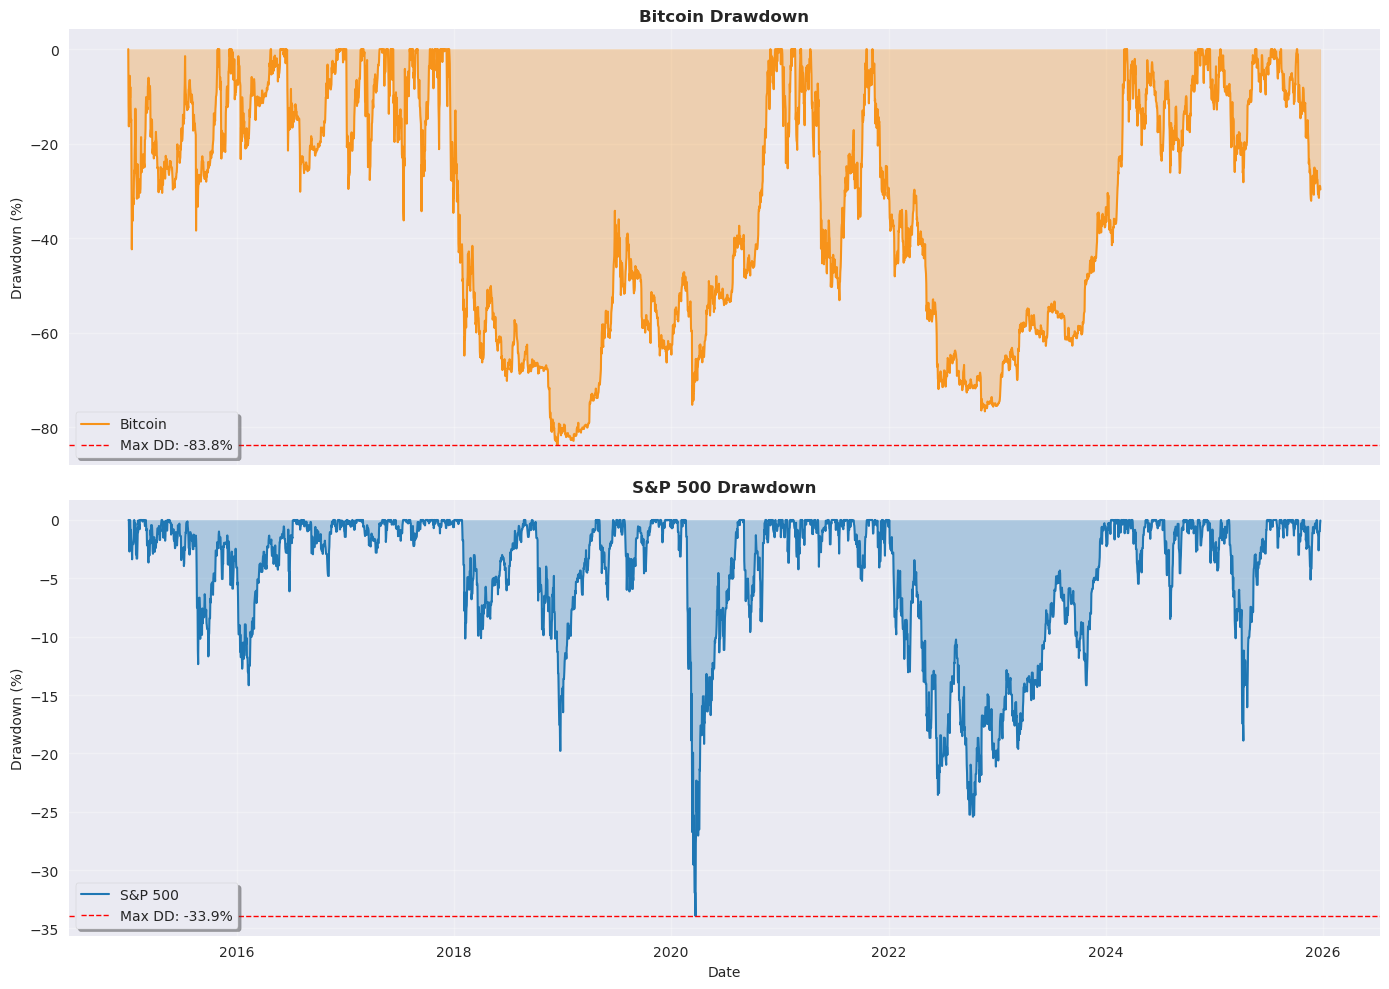


Key Insights:
- Bitcoin experienced a maximum drawdown of -83.8%
- S&P 500 experienced a maximum drawdown of -33.9%
- Bitcoin's drawdown was 2.5x larger
- Both assets show multiple drawdown periods, reflecting market cycles


In [9]:
# Visualization: Drawdown Analysis
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Bitcoin drawdown
axes[0].fill_between(dd_btc.index, 0, dd_btc * 100, color='#f7931a', alpha=0.3)
axes[0].plot(dd_btc.index, dd_btc * 100, color='#f7931a', linewidth=1.5, label='Bitcoin')
axes[0].axhline(y=btc_stats['Max Drawdown'] * 100, color='red', linestyle='--', 
                linewidth=1, label=f"Max DD: {btc_stats['Max Drawdown']:.1%}")
axes[0].set_title('Bitcoin Drawdown', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Drawdown (%)', fontsize=10)
axes[0].legend(loc='lower left', frameon=True, shadow=True)
axes[0].grid(True, alpha=0.3)
#axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# S&P 500 drawdown
axes[1].fill_between(dd_spx.index, 0, dd_spx * 100, color='#1f77b4', alpha=0.3)
axes[1].plot(dd_spx.index, dd_spx * 100, color='#1f77b4', linewidth=1.5, label='S&P 500')
axes[1].axhline(y=spx_stats['Max Drawdown'] * 100, color='red', linestyle='--', 
                linewidth=1, label=f"Max DD: {spx_stats['Max Drawdown']:.1%}")
axes[1].set_title('S&P 500 Drawdown', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Drawdown (%)', fontsize=10)
axes[1].set_xlabel('Date', fontsize=10)
axes[1].legend(loc='lower left', frameon=True, shadow=True)
axes[1].grid(True, alpha=0.3)
#axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print(f"- Bitcoin experienced a maximum drawdown of {btc_stats['Max Drawdown']:.1%}")
print(f"- S&P 500 experienced a maximum drawdown of {spx_stats['Max Drawdown']:.1%}")
print(f"- Bitcoin's drawdown was {abs(btc_stats['Max Drawdown']/spx_stats['Max Drawdown']):.1f}x larger")
print("- Both assets show multiple drawdown periods, reflecting market cycles")

## 4. Portfolio Construction

We construct three portfolios with annual rebalancing:

1. **Baseline Portfolio**: Traditional 80/20 stock/bond allocation
2. **5% Bitcoin Portfolio**: Modest Bitcoin exposure (75% SPX / 20% AGG / 5% BTC)
3. **10% Bitcoin Portfolio**: Higher Bitcoin exposure (70% SPX / 20% AGG / 10% BTC)

**Rebalancing Strategy**: At the end of each calendar year, portfolios are rebalanced to target weights. This discipline ensures we maintain desired risk exposure and benefit from the "buy low, sell high" dynamic.

In [10]:
def calculate_portfolio_returns(returns_df, weights, rebalance_freq='A'):
    """
    Calculate portfolio returns with periodic rebalancing
    
    Parameters:
    - returns_df: DataFrame with asset returns
    - weights: Dictionary of target weights {asset: weight}
    - rebalance_freq: 'A' for annual, 'Q' for quarterly, etc.
    """
    portfolio_returns = []
    current_weights = weights.copy()
    
    # Group by rebalancing period
    if rebalance_freq == 'A':
        periods = returns_df.groupby(returns_df.index.year)
    else:
        periods = [(None, returns_df)]  # No rebalancing
    
    for period_name, period_data in periods:
        # At start of period, reset to target weights
        current_weights = weights.copy()
        
        for date, row in period_data.iterrows():
            # Calculate portfolio return for this day
            port_return = sum(current_weights[asset] * row[asset] for asset in weights.keys())
            portfolio_returns.append((date, port_return))
            
            # Update weights based on returns (drift)
            total_value = sum(current_weights[asset] * (1 + row[asset]) for asset in weights.keys())
            for asset in weights.keys():
                current_weights[asset] = current_weights[asset] * (1 + row[asset]) / total_value
    
    return pd.Series([r[1] for r in portfolio_returns], index=[r[0] for r in portfolio_returns])

# Define portfolio allocations
portfolios = {
    'Baseline (80/20)': {'SPX': 0.80, 'AGG': 0.20, 'BTC': 0.00},
    '5% BTC (75/20/5)': {'SPX': 0.75, 'AGG': 0.20, 'BTC': 0.05},
    '10% BTC (70/20/10)': {'SPX': 0.70, 'AGG': 0.20, 'BTC': 0.10}
}

# Calculate returns for each portfolio
portfolio_returns = {}
for name, weights in portfolios.items():
    portfolio_returns[name] = calculate_portfolio_returns(returns, weights, rebalance_freq='A')

# Combine into DataFrame
portfolio_returns_df = pd.DataFrame(portfolio_returns)

print("Portfolio returns calculated with annual rebalancing")
print(f"\nSample of daily portfolio returns:")
portfolio_returns_df.head()

Portfolio returns calculated with annual rebalancing

Sample of daily portfolio returns:


,Baseline (80/20),5% BTC (75/20/5),10% BTC (70/20/10)
2015-01-03,0.0000,-0.0060,-0.0119
2015-01-04,0.0000,-0.0022,-0.0045
2015-01-05,-0.0142,-0.0117,-0.0091
2015-01-06,-0.0066,-0.0040,-0.0013
2015-01-07,0.0092,0.0102,0.0112


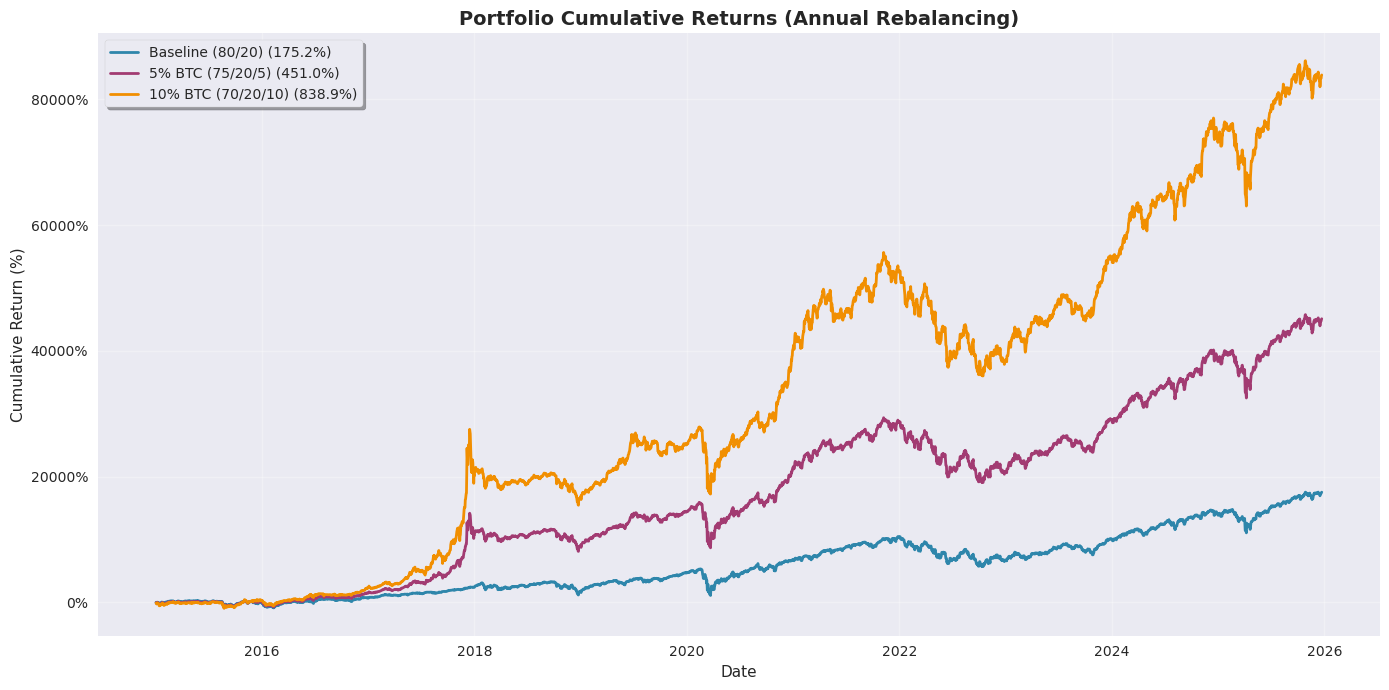


Key Insights:
- Portfolios with Bitcoin allocation show enhanced returns
- Higher Bitcoin allocation increases both potential returns and volatility
- Annual rebalancing enforces discipline and captures mean reversion


In [11]:
# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns_df).cumprod()

# Visualization: Cumulative Returns
fig, ax = plt.subplots(figsize=(14, 7))

colors = ['#2E86AB', '#A23B72', '#F18F01']
for idx, (name, color) in enumerate(zip(cumulative_returns.columns, colors)):
    final_return = (cumulative_returns[name].iloc[-1] - 1) * 100
    ax.plot(cumulative_returns.index, (cumulative_returns[name] - 1) * 100, 
            label=f"{name} ({final_return:.1f}%)", color=color, linewidth=2)

ax.set_title('Portfolio Cumulative Returns (Annual Rebalancing)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Cumulative Return (%)', fontsize=11)
ax.legend(loc='upper left', frameon=True, shadow=True, fontsize=10)
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("- Portfolios with Bitcoin allocation show enhanced returns")
print("- Higher Bitcoin allocation increases both potential returns and volatility")
print("- Annual rebalancing enforces discipline and captures mean reversion")

## 5. Risk-Adjusted Performance Metrics

We evaluate portfolios using multiple risk-adjusted metrics:

### 5.1 Sharpe Ratio
Measures excess return per unit of total volatility. Higher is better.
$$\text{Sharpe} = \frac{R_p - R_f}{\sigma_p}$$

### 5.2 Sortino Ratio
Similar to Sharpe, but only considers downside volatility (preferred for asymmetric returns). Higher is better.
$$\text{Sortino} = \frac{R_p - R_f}{\sigma_{downside}}$$

### 5.3 Upside/Downside Capture
Measures how well a portfolio captures market gains vs. losses relative to a benchmark.
- **Upside Capture > 100%**: Outperforms in up markets
- **Downside Capture < 100%**: Better protection in down markets

In [12]:
def calculate_sharpe_ratio(returns_series, risk_free_rate=0.02):
    """Calculate annualized Sharpe ratio"""
    excess_returns = returns_series - risk_free_rate/252
    return np.sqrt(252) * excess_returns.mean() / returns_series.std()

def calculate_sortino_ratio(returns_series, risk_free_rate=0.02):
    """Calculate annualized Sortino ratio"""
    excess_returns = returns_series - risk_free_rate/252
    downside_returns = returns_series[returns_series < 0]
    downside_std = downside_returns.std()
    return np.sqrt(252) * excess_returns.mean() / downside_std

def calculate_capture_ratios(portfolio_returns, benchmark_returns, threshold=0):
    """Calculate upside and downside capture ratios"""
    # Identify up and down periods for benchmark
    up_periods = benchmark_returns > threshold
    down_periods = benchmark_returns < threshold
    
    # Calculate average returns in each period
    portfolio_up = portfolio_returns[up_periods].mean()
    portfolio_down = portfolio_returns[down_periods].mean()
    benchmark_up = benchmark_returns[up_periods].mean()
    benchmark_down = benchmark_returns[down_periods].mean()
    
    upside_capture = (portfolio_up / benchmark_up) if benchmark_up != 0 else np.nan
    downside_capture = (portfolio_down / benchmark_down) if benchmark_down != 0 else np.nan
    
    return upside_capture, downside_capture

# Calculate metrics for each portfolio
metrics = {}
for name in portfolio_returns_df.columns:
    port_ret = portfolio_returns_df[name]
    
    sharpe = calculate_sharpe_ratio(port_ret)
    sortino = calculate_sortino_ratio(port_ret)
    
    # Use SPX as benchmark for capture ratios
    upside_cap, downside_cap = calculate_capture_ratios(port_ret, returns['SPX'])
    
    # Calculate annualized return and volatility
    ann_return = (1 + port_ret.mean()) ** 252 - 1
    ann_vol = port_ret.std() * np.sqrt(252)
    
    metrics[name] = {
        'Ann. Return': ann_return,
        'Ann. Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Upside Capture': upside_cap,
        'Downside Capture': downside_cap
    }

# Create summary table
metrics_df = pd.DataFrame(metrics).T

print("Risk-Adjusted Performance Metrics\n" + "="*80)
print("\nBenchmark: S&P 500 (for capture ratios)")
print("Risk-free rate: 2.0% (annualized)\n")

# Format for display
display_df = metrics_df.copy()
display_df['Ann. Return'] = display_df['Ann. Return'].map('{:.2%}'.format)
display_df['Ann. Volatility'] = display_df['Ann. Volatility'].map('{:.2%}'.format)
display_df['Sharpe Ratio'] = display_df['Sharpe Ratio'].map('{:.3f}'.format)
display_df['Sortino Ratio'] = display_df['Sortino Ratio'].map('{:.3f}'.format)
display_df['Upside Capture'] = display_df['Upside Capture'].map('{:.2%}'.format)
display_df['Downside Capture'] = display_df['Downside Capture'].map('{:.2%}'.format)

display_df

Risk-Adjusted Performance Metrics

Benchmark: S&P 500 (for capture ratios)
Risk-free rate: 2.0% (annualized)



,Ann. Return,Ann. Volatility,Sharpe Ratio,Sortino Ratio,Upside Capture,Downside Capture
Baseline (80/20),7.33%,11.87%,0.427,0.433,80.48%,80.38%
5% BTC (75/20/5),12.32%,13.33%,0.722,0.865,82.24%,76.64%
10% BTC (70/20/10),16.53%,15.66%,0.850,1.072,83.25%,73.22%


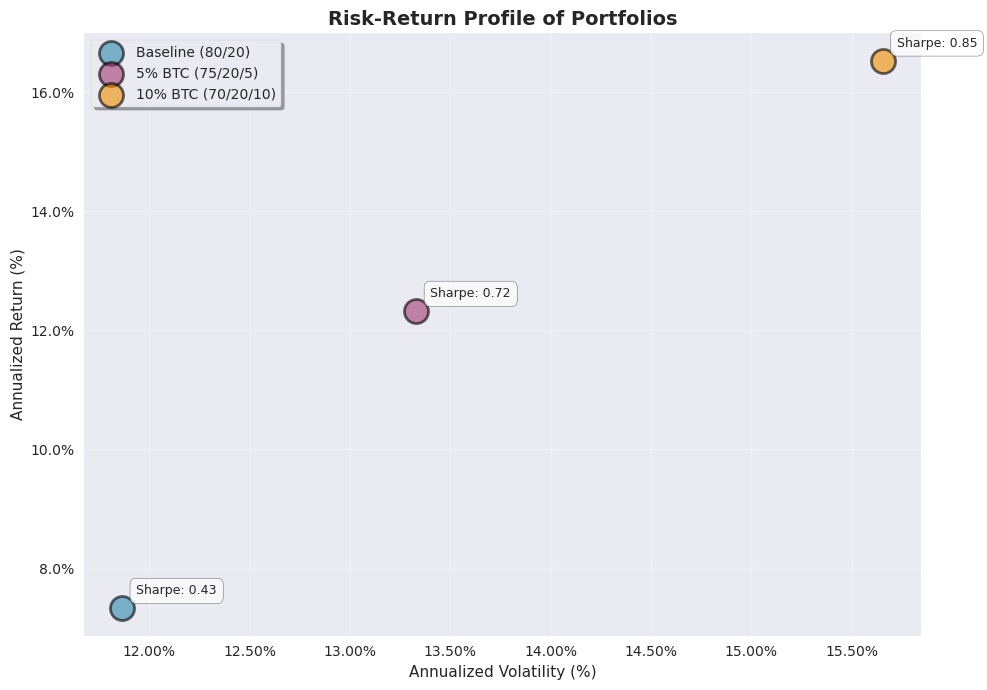


Key Insights:
- Bitcoin allocations increase both returns and volatility
- Sharpe ratios help identify risk-adjusted performance
- Optimal allocation depends on investor risk tolerance


In [13]:
# Visualization: Risk-Return Scatter
fig, ax = plt.subplots(figsize=(10, 7))

colors_map = {'Baseline (80/20)': '#2E86AB', '5% BTC (75/20/5)': '#A23B72', 
              '10% BTC (70/20/10)': '#F18F01'}

for name in metrics_df.index:
    x = metrics_df.loc[name, 'Ann. Volatility'] * 100
    y = metrics_df.loc[name, 'Ann. Return'] * 100
    sharpe = metrics_df.loc[name, 'Sharpe Ratio']
    
    ax.scatter(x, y, s=300, alpha=0.6, color=colors_map[name], 
               edgecolors='black', linewidth=2, label=name)
    ax.annotate(f"Sharpe: {sharpe:.2f}", 
                xy=(x, y), xytext=(10, 10), textcoords='offset points',
                fontsize=9, bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))

ax.set_title('Risk-Return Profile of Portfolios', fontsize=14, fontweight='bold')
ax.set_xlabel('Annualized Volatility (%)', fontsize=11)
ax.set_ylabel('Annualized Return (%)', fontsize=11)
ax.legend(loc='upper left', frameon=True, shadow=True)
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("- Bitcoin allocations increase both returns and volatility")
print("- Sharpe ratios help identify risk-adjusted performance")
print("- Optimal allocation depends on investor risk tolerance")

## 6. Drawdown Analysis for Portfolios

Maximum drawdown analysis for each portfolio helps us understand downside risk exposure. This is particularly important for:
- **Retirement accounts**: Where sequence-of-returns risk matters
- **Psychological comfort**: Understanding worst-case scenarios
- **Risk management**: Setting appropriate position sizes

In [14]:
# Calculate drawdowns for each portfolio
portfolio_drawdowns = {}
portfolio_dd_stats = {}

for name in portfolio_returns_df.columns:
    cumulative = (1 + portfolio_returns_df[name]).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    
    portfolio_drawdowns[name] = drawdown
    
    # Calculate statistics
    max_dd = drawdown.min()
    max_dd_date = drawdown.idxmin()
    peak_date = cumulative.loc[:max_dd_date].idxmax()
    duration_days = (max_dd_date - peak_date).days
    
    portfolio_dd_stats[name] = {
        'Max Drawdown': max_dd,
        'Peak Date': peak_date,
        'Trough Date': max_dd_date,
        'Duration (days)': duration_days
    }

# Display statistics
print("Portfolio Drawdown Statistics\n" + "="*70)
for name, stats in portfolio_dd_stats.items():
    print(f"\n{name}:")
    print(f"  Max Drawdown: {stats['Max Drawdown']:.2%}")
    print(f"  Peak Date: {stats['Peak Date'].strftime('%Y-%m-%d')}")
    print(f"  Trough Date: {stats['Trough Date'].strftime('%Y-%m-%d')}")
    print(f"  Duration: {stats['Duration (days)']} days")

Portfolio Drawdown Statistics

Baseline (80/20):
  Max Drawdown: -27.55%
  Peak Date: 2020-02-19
  Trough Date: 2020-03-23
  Duration: 33 days

5% BTC (75/20/5):
  Max Drawdown: -27.80%
  Peak Date: 2020-02-14
  Trough Date: 2020-03-23
  Duration: 38 days

10% BTC (70/20/10):
  Max Drawdown: -32.19%
  Peak Date: 2017-12-16
  Trough Date: 2018-12-25
  Duration: 374 days


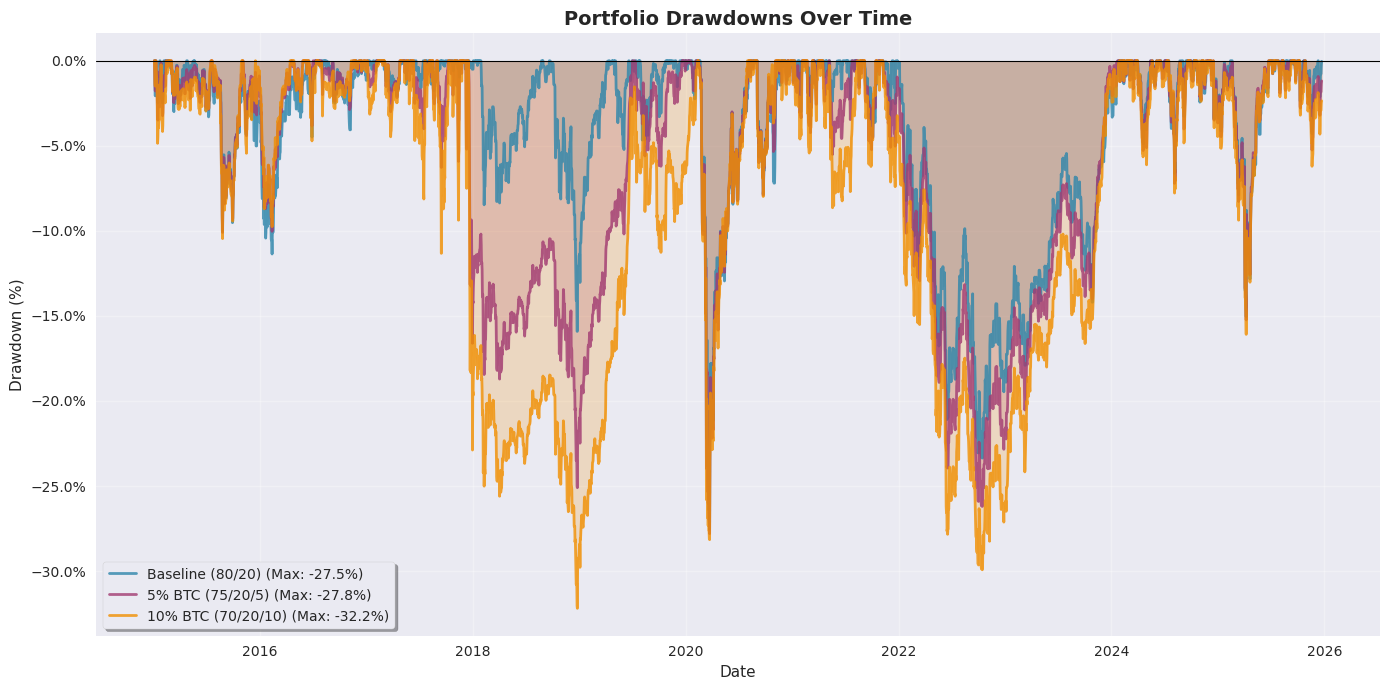


Key Insights:
- All portfolios experience drawdowns during market downturns
- Bitcoin allocation increases maximum drawdown magnitude
- Recovery periods vary based on portfolio composition


In [16]:
# Visualization: Portfolio Drawdowns
fig, ax = plt.subplots(figsize=(14, 7))

colors = ['#2E86AB', '#A23B72', '#F18F01']
for idx, (name, color) in enumerate(zip(portfolio_drawdowns.keys(), colors)):
    dd = portfolio_drawdowns[name] 
    max_dd = portfolio_dd_stats[name]['Max Drawdown'] * 100
    ax.plot(dd.index, dd, label=f"{name} (Max: {max_dd:.1f}%)", 
            color=color, linewidth=2, alpha=0.8)
    ax.fill_between(dd.index, 0, dd, color=color, alpha=0.2)

ax.set_title('Portfolio Drawdowns Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Drawdown (%)', fontsize=11)
ax.legend(loc='lower left', frameon=True, shadow=True)
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("- All portfolios experience drawdowns during market downturns")
print("- Bitcoin allocation increases maximum drawdown magnitude")
print("- Recovery periods vary based on portfolio composition")

## 7. Expected Shortfall (Conditional Value at Risk)

Expected Shortfall (ES), also known as Conditional Value at Risk (CVaR), measures the expected loss in the worst X% of cases. Unlike Value at Risk (VaR) which only identifies a threshold, ES tells us the average loss beyond that threshold.

**Interpretation**: 
- ES at 95% confidence level = average loss in the worst 5% of days
- Lower (more negative) values indicate greater tail risk
- More informative than VaR for extreme events

In [17]:
def calculate_expected_shortfall(returns_series, confidence_level=0.95):
    """
    Calculate Expected Shortfall (CVaR) at given confidence level
    Returns ES as a positive number (magnitude of loss)
    """
    var_threshold = returns_series.quantile(1 - confidence_level)
    es = returns_series[returns_series <= var_threshold].mean()
    return es

# Calculate ES for different confidence levels
confidence_levels = [0.90, 0.95, 0.99]
es_results = {}

for conf in confidence_levels:
    es_row = {}
    for name in portfolio_returns_df.columns:
        es = calculate_expected_shortfall(portfolio_returns_df[name], conf)
        es_row[name] = es
    es_results[f"{int(conf*100)}% ES"] = es_row

es_df = pd.DataFrame(es_results).T

print("Expected Shortfall (CVaR) Analysis\n" + "="*70)
print("\nExpected loss in worst X% of days (daily returns)\n")

# Format for display
display_es = es_df.copy() * 100
print(display_es.to_string(float_format=lambda x: f"{x:.3f}%"))

print("\nNote: Higher magnitude (more negative) = greater tail risk")

Expected Shortfall (CVaR) Analysis

Expected loss in worst X% of days (daily returns)

        Baseline (80/20)  5% BTC (75/20/5)  10% BTC (70/20/10)
90% ES           -1.364%           -1.461%             -1.649%
95% ES           -1.881%           -2.002%             -2.263%
99% ES           -3.334%           -3.546%             -4.031%

Note: Higher magnitude (more negative) = greater tail risk


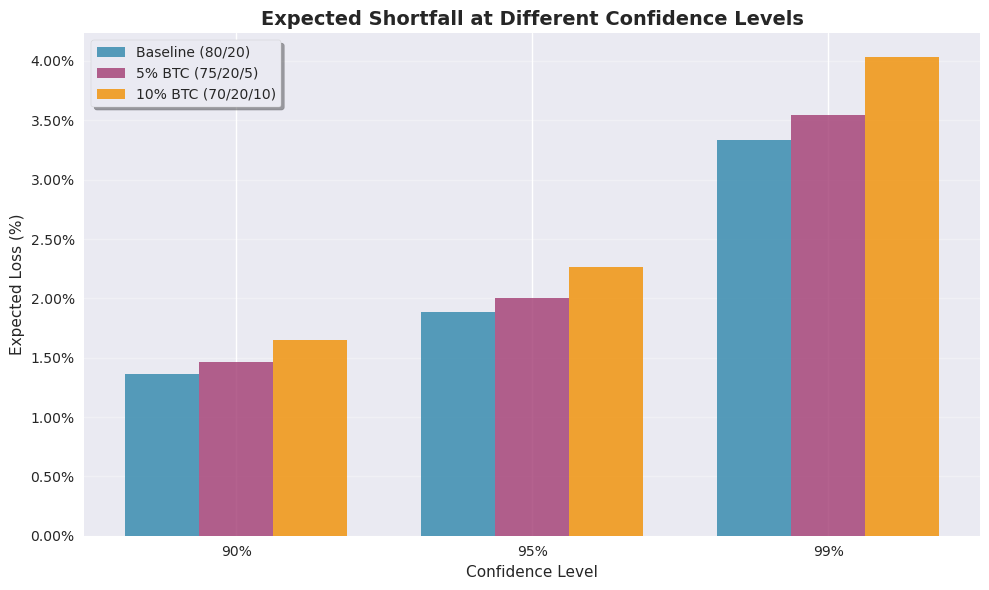


Key Insights:
- Expected Shortfall increases with Bitcoin allocation
- Tail risk (99% ES) significantly higher for Bitcoin portfolios
- Investors must weigh enhanced returns against tail risk exposure


In [19]:
# Visualization: Expected Shortfall Comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(confidence_levels))
width = 0.25

colors = ['#2E86AB', '#A23B72', '#F18F01']
for idx, (name, color) in enumerate(zip(es_df.columns, colors)):
    values = [abs(es_df.loc[f"{int(conf*100)}% ES", name]) for conf in confidence_levels]
    ax.bar(x + idx*width, values, width, label=name, color=color, alpha=0.8)

ax.set_title('Expected Shortfall at Different Confidence Levels', fontsize=14, fontweight='bold')
ax.set_xlabel('Confidence Level', fontsize=11)
ax.set_ylabel('Expected Loss (%)', fontsize=11)
ax.set_xticks(x + width)
ax.set_xticklabels([f"{int(c*100)}%" for c in confidence_levels])
ax.legend(frameon=True, shadow=True)
ax.grid(True, alpha=0.3, axis='y')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("- Expected Shortfall increases with Bitcoin allocation")
print("- Tail risk (99% ES) significantly higher for Bitcoin portfolios")
print("- Investors must weigh enhanced returns against tail risk exposure")

## 8. Comprehensive Performance Summary

This final section synthesizes all metrics to provide a holistic view of portfolio performance.

In [20]:
# Create comprehensive summary table
summary = {}

for name in portfolio_returns_df.columns:
    port_ret = portfolio_returns_df[name]
    cumulative = (1 + port_ret).cumprod()
    
    # Calculate total return
    total_return = cumulative.iloc[-1] - 1
    
    # Calculate CAGR
    years = (port_ret.index[-1] - port_ret.index[0]).days / 365.25
    cagr = (1 + total_return) ** (1/years) - 1
    
    summary[name] = {
        'Total Return': total_return,
        'CAGR': cagr,
        'Annualized Vol': port_ret.std() * np.sqrt(252),
        'Sharpe Ratio': metrics_df.loc[name, 'Sharpe Ratio'],
        'Sortino Ratio': metrics_df.loc[name, 'Sortino Ratio'],
        'Max Drawdown': portfolio_dd_stats[name]['Max Drawdown'],
        'Upside Capture': metrics_df.loc[name, 'Upside Capture'],
        'Downside Capture': metrics_df.loc[name, 'Downside Capture'],
        'ES (95%)': calculate_expected_shortfall(port_ret, 0.95)
    }

summary_df = pd.DataFrame(summary).T

print("\n" + "="*90)
print("COMPREHENSIVE PORTFOLIO PERFORMANCE SUMMARY")
print("="*90 + "\n")

# Format for display
display_summary = summary_df.copy()
pct_cols = ['Total Return', 'CAGR', 'Annualized Vol', 'Max Drawdown', 
            'Upside Capture', 'Downside Capture', 'ES (95%)']
for col in pct_cols:
    display_summary[col] = display_summary[col].map('{:.2%}'.format)
display_summary['Sharpe Ratio'] = display_summary['Sharpe Ratio'].map('{:.3f}'.format)
display_summary['Sortino Ratio'] = display_summary['Sortino Ratio'].map('{:.3f}'.format)

print(display_summary.to_string())

print("\n" + "="*90)


COMPREHENSIVE PORTFOLIO PERFORMANCE SUMMARY

                   Total Return    CAGR Annualized Vol Sharpe Ratio Sortino Ratio Max Drawdown Upside Capture Downside Capture ES (95%)
Baseline (80/20)        175.19%   9.67%         11.87%        0.427         0.433      -27.55%         80.48%           80.38%   -1.88%
5% BTC (75/20/5)        451.04%  16.83%         13.33%        0.722         0.865      -27.80%         82.24%           76.64%   -2.00%
10% BTC (70/20/10)      838.90%  22.65%         15.66%        0.850         1.072      -32.19%         83.25%           73.22%   -2.26%



## 9. Final Insights and Conclusions

### Key Findings:

**Volatility**: Bitcoin exhibits significantly higher volatility than traditional assets across all time horizons, with volatility varying considerably over time.

**Drawdowns**: Bitcoin experiences deeper and potentially longer drawdowns compared to the S&P 500, indicating higher downside risk that investors must be prepared to weather.

**Returns**: Portfolios with Bitcoin allocation historically delivered higher total returns, with the enhancement proportional to allocation size.

**Risk-Adjusted Performance**: 
- Sharpe and Sortino ratios help quantify whether increased returns justify additional risk
- Results vary by time period and should be evaluated in context of investor goals

**Capture Ratios**: Bitcoin-enhanced portfolios show different upside/downside capture characteristics, affecting their behavior in bull vs. bear markets.

**Tail Risk**: Expected Shortfall analysis reveals that Bitcoin allocations increase worst-case scenario losses, a critical consideration for risk management.

### Investment Implications:

1. **For Growth-Oriented Investors**: Small Bitcoin allocations (5-10%) can potentially enhance returns while maintaining reasonable risk levels through diversification.

2. **For Conservative Investors**: The increased volatility and drawdown risk may outweigh return benefits, especially for those with shorter time horizons.

3. **Rebalancing Discipline**: Annual rebalancing is crucial to maintain target allocations and capture mean reversion benefits.

4. **Time Horizon Matters**: Bitcoin's high volatility makes it most appropriate for long-term investors who can weather significant drawdowns.

### Caveats:

- Past performance does not guarantee future results
- Bitcoin is a relatively young asset with limited history
- Regulatory, technological, and market structure risks remain
- Individual circumstances (risk tolerance, time horizon, goals) should drive allocation decisions

### Recommendations:

Investors considering Bitcoin should:
1. Start with small allocations (5% or less)
2. Maintain strict rebalancing discipline
3. Ensure sufficient liquidity and emergency funds
4. Understand and accept the possibility of significant losses
5. Consider Bitcoin as part of a diversified portfolio, not as a standalone investment